# wrp-2
`wrp-2` è una modello piu grande e potente di `wrp-1` in grado di individuare dati mancanti e riempirli in modo intelligente, 
queso è possibile perché `wrp-2` è diviso in 2 parti:
- un algoritmo `KNN` che infierisce sui dati riempiendo eventuali buchi
- una rete neurale per apprendimento profondo che stima il peso del gatto

`wrp-2` è in grado di supportare fino ad 1 dato mancante, stimando quale possa essere il valore basandosi su esperienze passate per scegliere come riempire il buco in modo inteligente ed il più vicino alla realtà possibile

In [134]:
import os
from pathlib import Path
import joblib

import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [116]:
# Carica il dataset completo
df = pd.read_csv("../data/training_set.csv")
binary_columns = ['pelo_lungo', 'sterilizzato', 'vive_interno']  # valori 0/1



# Nelle colonne dove i dati sono binari,
# potrebbero essere presenti dei "Si" e "No"
# o il datatype sbagliato, questa funzione si occupa
# di assicurare che il valore in queste colonne sia sempre e solo 0/1
def ensure_binary(col: pd.Series) -> pd.Series:
    binary_map = {
        1: 1,
        0: 0,
        '1': 1,
        '0': 0,
        'Si': 1,
        'No': 0
    }
    return col.map(binary_map)

# Assicurati che binary_columns abbia solo 0 e 1
for col in binary_columns:
    df[col] = ensure_binary(df[col])


# righe senza nessun valore mancante (per addestrare l'imputer)
df_complete = df.dropna()

# righe con esattamente UN valore mancante (da completare)
rows_with_nan = df[df.isnull().sum(axis=1) == 1].copy()

# righe con più di un valore mancante (opzionale, per ora le scartiamo)
rows_to_discard = df[df.isnull().sum(axis=1) > 1]

print(f"Trovate {len(df_complete)} righe complete.")
print(f"Trovate {len(rows_with_nan)} righe con un valore mancante da imputare.")
print(f"Scartate {len(rows_to_discard)} righe con troppi valori mancanti.")

del df_complete, rows_to_discard, rows_with_nan

Trovate 4869 righe complete.
Trovate 29 righe con un valore mancante da imputare.
Scartate 0 righe con troppi valori mancanti.


In [111]:
def create_imputer(df: pd.DataFrame, n_neighbours: int = 5):
    features = ['eta_mesi', 'razza', 'sesso', 'peso_nascita_kg', 'lunghezza_cm', 
                'altezza_spalla_cm', 'attivita_giornaliera', 'quantita_cibo_giorno_g', 
                'tipo_cibo', 'pelo_lungo', 'sterilizzato', 'temperatura_media_zona', 
                'vive_interno']
    
    categorical_cols = ['razza', 'sesso', 'tipo_cibo']
    
    X_complete = df[features].copy()
    X_complete[categorical_cols] = X_complete[categorical_cols].fillna('Unknown')

    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_complete[categorical_cols] = encoder.fit_transform(X_complete[categorical_cols])

    imputer = KNNImputer(n_neighbors=n_neighbours)
    imputer.fit(X_complete)

    return imputer, encoder


In [ ]:
def crate_preprocessor(df: pd.DataFrame):
    categorical_columns = ['razza', 'sesso', 'tipo_cibo'] # puramente stringe di testo
    binary_columns = ['pelo_lungo', 'sterilizzato', 'vive_interno']  # valori 0/1
    numerical_columns = df.columns.drop(categorical_columns + binary_columns).tolist() # valori numerici


    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),
            ('bin', 'passthrough', binary_columns),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ])
    preprocessor.fit(df)
    return preprocessor

In [ ]:
class DataEncoder:
    def __init__(self, imputer: KNNImputer, ord_encoder: OrdinalEncoder, preprocessor: ColumnTransformer):
        self.imputer = imputer
        self.ord_encoder = ord_encoder
        self.preprocessor = preprocessor

    def __call__(self, df: pd.DataFrame):
        return self.process(df)

    def process(self, df: pd.DataFrame):
        df = self._impute_missing_data(df)
        df_clean, ids = self._preprocess_data(df)
        X_processed = self.preprocessor.transform(df_clean)
        return X_processed, ids
        

    def _impute_missing_data(self, df: pd.DataFrame) -> pd.DataFrame:
        # Seleziona solo le feature dal set di dati completo
        features = ['eta_mesi', 'razza', 'sesso', 'peso_nascita_kg', 'lunghezza_cm', 
                    'altezza_spalla_cm', 'attivita_giornaliera', 'quantita_cibo_giorno_g', 
                    'tipo_cibo', 'pelo_lungo', 'sterilizzato', 'temperatura_media_zona', 
                    'vive_interno']
        categorical_cols = ['razza', 'sesso', 'tipo_cibo']

        
        df_complete = df.dropna()
        rows_with_nan = df[df[features].isnull().any(axis=1)].copy()
        
        # prepara il set con i dati mancanti
        X_to_impute = rows_with_nan[features].copy()
        X_to_impute[categorical_cols] = X_to_impute[categorical_cols].fillna('Unknown')
        X_to_impute[categorical_cols] = self.ord_encoder.transform(X_to_impute[categorical_cols])

        # applica l'imputer per riempire i valori mancanti
        X_imputed_array = self.imputer.transform(X_to_impute)
        df_imputed = pd.DataFrame(X_imputed_array, columns=features)

        # riconverti le colonne categoriche al loro formato originale
        for col in categorical_cols:
            df_imputed[col] = df_imputed[col].round().astype(int)
        df_imputed[categorical_cols] = self.ord_encoder.inverse_transform(df_imputed[categorical_cols])

        # Aggiungi di nuovo l'ID del gatto e il peso
        df_imputed['id_gatto'] = rows_with_nan['id_gatto'].values
        try:
            df_imputed['peso_adulto_kg'] = rows_with_nan['peso_adulto_kg'].values
        except:
            pass
        return pd.concat([df_complete, df_imputed], ignore_index=True)
    
    def _preprocess_data(self, df: pd.DataFrame):
        df_clean = df.copy()
        
        # Rimuovi id_gatto
        if 'id_gatto' in df_clean.columns:
            ids = df_clean['id_gatto'].astype(int)
            df_clean = df_clean.drop(columns=['id_gatto'])
        else:
            ids = range(len(df_clean))
        
        # Gestisci valori mancanti numerici
        numeric_cols = ['eta_mesi', 'peso_nascita_kg', 'lunghezza_cm', 'altezza_spalla_cm', 
                    'attivita_giornaliera', 'quantita_cibo_giorno_g', 'temperatura_media_zona']
        
        for col in numeric_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col] = df_clean[col].fillna(df_clean[col].median() if not df_clean[col].isna().all() else 0)
        
        # Gestisci valori mancanti binari
        binary_cols = ['pelo_lungo', 'sterilizzato', 'vive_interno']
        for col in binary_cols:
            if col in df_clean.columns:
                df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
                df_clean[col] = df_clean[col].fillna(0)
                df_clean[col] = df_clean[col].apply(lambda x: 1 if x == 1 else 0)
        
        # Gestisci categorie sconosciute
        categorical_cols = ['razza', 'sesso', 'tipo_cibo']
        for col in categorical_cols:
            if col in df_clean.columns:
                df_clean[col] = df_clean[col].fillna('Unknown')
                # Converti a stringa per sicurezza
                df_clean[col] = df_clean[col].astype(str)
        
        return df_clean, ids
    
    def _ensure_binary(col: pd.Series) -> pd.Series:
        """
        Nelle colonne dove i dati sono binari,
        potrebbero essere presenti dei "Si" e "No"
        o il datatype sbagliato, questa funzione si occupa
        di assicurare che il valore in queste colonne sia sempre e solo 0/1
        """
        binary_map = {
            1: 1,       0: 0,
            '1': 1,     '0': 0,
            'Si': 1,    'No': 0
        }
        return col.map(binary_map)

# usa lo stesso ColumnTransformer di wrp-1
preprocessor: ColumnTransformer = joblib.load("../models/wrp-1/preprocessor.pkl")
data_encoder = DataEncoder(*create_imputer(df), preprocessor)

In [86]:
data_encoder._impute_missing_data(df).isnull().sum()

id_gatto                  0
eta_mesi                  0
razza                     0
sesso                     0
peso_nascita_kg           0
lunghezza_cm              0
altezza_spalla_cm         0
attivita_giornaliera      0
quantita_cibo_giorno_g    0
tipo_cibo                 0
pelo_lungo                0
sterilizzato              0
temperatura_media_zona    0
vive_interno              0
peso_adulto_kg            0
dtype: int64

In [87]:
def preprocess_training_data(df: pd.DataFrame):
    df_clean = df.copy()
    
    # Rimuovi colonne non necessarie
    if 'id_gatto' in df_clean.columns:
        df_clean = df_clean.drop(columns=['id_gatto'])
    
    # Gestisci valori mancanti numerici con la mediana
    numeric_cols = ['eta_mesi', 'peso_nascita_kg', 'lunghezza_cm', 'altezza_spalla_cm', 
                   'attivita_giornaliera', 'quantita_cibo_giorno_g', 'temperatura_media_zona']
    for col in numeric_cols:
        if col in df_clean.columns:
            median_val = df_clean[col].median()
            df_clean[col] = df_clean[col].fillna(median_val)
            
    # Gestisci le altre colonne (categoriche, binarie) come preferisci,
    # ad esempio riempiendo con una moda o un valore specifico come 'Unknown' o 0
    
    X = df_clean.drop(columns=['peso_adulto_kg'])
    y = df_clean['peso_adulto_kg']
    
    return X, y

# Applica la pulizia
df = data_encoder._impute_missing_data(df)
X, y = preprocess_training_data(df)
del df # non verrà piu usato, quindi possiamo liberare memoria

In [89]:
X_processed = preprocessor.fit_transform(X)
y = y.values

In [90]:
X_processed.shape

(4898, 24)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2)

In [ ]:
model = Sequential([
    Input(shape=(X_processed.shape[1],)),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    Dropout(0.1),
    
    Dense(68, activation='relu'),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1),
], name='wrp-2')

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

#### Architettura alternativa
```py
model = Sequential([
    Input(shape=(X_processed.shape[1],)),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(68, activation='relu'),
    BatchNormalization(),
    Dropout(0.1),
    
    Dense(16, activation='relu'),
    Dense(1),
])

model.compile(
optimizer=Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)
```

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=1e-1,
            patience=10,
            min_lr=1e-6
        )
    ],
)

Epoch 1/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - loss: 8.6428 - mae: 1.4414 - val_loss: 1.1091 - val_mae: 0.7483 - learning_rate: 0.0010
Epoch 2/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 4.5111 - mae: 1.1199 - val_loss: 1.4269 - val_mae: 1.0311 - learning_rate: 0.0010
Epoch 3/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 2.8246 - mae: 1.0694 - val_loss: 0.9115 - val_mae: 0.7978 - learning_rate: 0.0010
Epoch 4/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - loss: 2.2290 - mae: 1.0157 - val_loss: 0.2793 - val_mae: 0.3145 - learning_rate: 0.0010
Epoch 5/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 2.2301 - mae: 1.0372 - val_loss: 0.6893 - val_mae: 0.7109 - learning_rate: 0.0010
Epoch 6/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - loss: 1.2653 - mae: 0.8373 - val_loss: 0.5171 - val_mae: 0.6123 - learning_rate: 0.0010
Epoch 7/200
245/245 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - loss: 1.0562 - mae: 0.7928 - val_loss: 0.4074 - val_mae: 0.5290 - learning

In [94]:
# valutazione 
loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test MAE: {mae:.4f}")

Test Loss (MSE): 0.0969
Test MAE: 0.2487


In [95]:
# Predizione di esempio
predictions = model.predict(X_test[:5])
print("Predizioni vs Valori reali:")
for i in range(5):
    print(f"Predetto: {predictions[i][0]:.2f} kg, Reale: {y_test[i]:.2f} kg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predizioni vs Valori reali:
Predetto: 7.39 kg, Reale: 7.23 kg
Predetto: 5.71 kg, Reale: 5.43 kg
Predetto: 7.46 kg, Reale: 7.19 kg
Predetto: 6.45 kg, Reale: 6.38 kg
Predetto: 4.44 kg, Reale: 4.46 kg


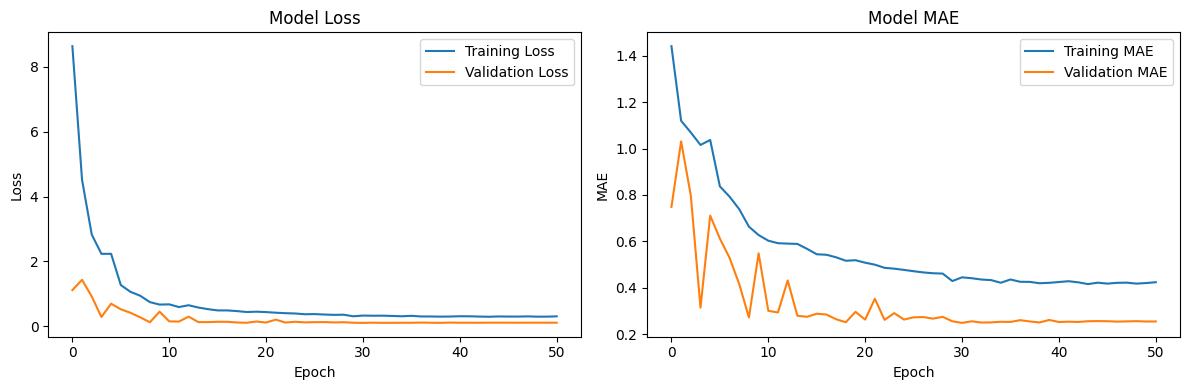

In [96]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [120]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
R² Score: 0.9254


### R² score
L'R² Score del modello è molto alto (quasi 1.0) il che vuol dire che è riuscito a generalizzare bene i dati in input

> R² score è una metrica spesso usata per determinare quanto un modello di regressione sia performante.  
>
> Un R² score > 0,85 è gia un risultato buono per un modello, con risultato pari 1.0 a rappresentare un modello perfetto (100% giusto, 0 di errore, estremamente difficile per una rete neurale non andata in overfitting)

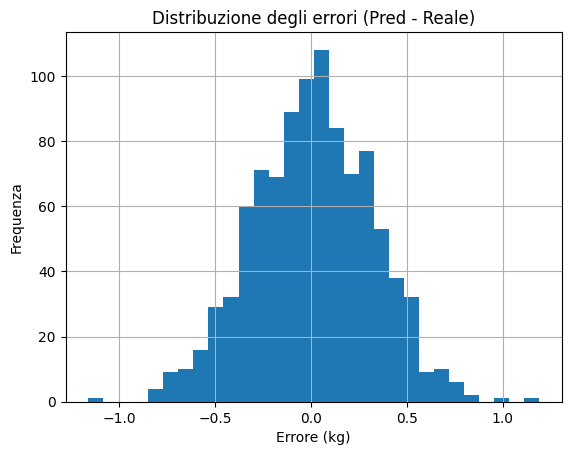

In [121]:
import matplotlib.pyplot as plt

errors = y_pred.flatten() - y_test
plt.hist(errors, bins=30)
plt.title("Distribuzione degli errori (Pred - Reale)")
plt.xlabel("Errore (kg)")
plt.ylabel("Frequenza")
plt.grid(True)
plt.show()


Dal grafico possiamo vedere che la maggior parte della distribuzione dell'errore sta attorno a 0,25-0,30 dallo 0 (anche questo un risultato molto buono)

In [97]:
# Architettura del modello
model.summary()

Model: "wrp-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 1024)           │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 68)             │         8,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 68)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 16)             │         1,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,322,353 (20.30 MB)

 Trainable params: 1,774,117 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,548,236 (13.54 MB)

In [128]:

def save_model(model: Sequential, preprocessor: ColumnTransformer, data_encoder: DataEncoder):
    model_name: str = str(model.name)
    dir_path = Path("..") / "models" / model_name
    model_path = dir_path / (model_name + ".keras")
    preprocessor_path = dir_path / "preprocessor.pkl"
    encoder_path = dir_path / (model_name + "-encoder.pkl")

    os.makedirs(model_path.parent, exist_ok=True)

    model.save(model_path)
    joblib.dump(preprocessor, preprocessor_path)
    joblib.dump(data_encoder,encoder_path)

save_model(model, preprocessor, data_encoder)

In [130]:
model: Sequential = load_model("../models/wrp-2/wrp-2.keras")
encoder: DataEncoder = joblib.load("../models/wrp-2/wrp-2-encoder.pkl")

# Carica test set
test_df = pd.read_csv("../data/test_set.csv")


# processa i dati
X_processed, ids = encoder(test_df)

# determina il peso del gatto
predictions = model.predict(X_processed)

# Salva risultati
os.makedirs("out", exist_ok=True)
with open("../out/risultati-wrp-2.csv", "w") as out:
    out.write("id_gatto,peso_previsto_kg\n")
    for id_gatto, peso in zip(ids, predictions):
        out.write(f"{id_gatto},{peso[0]:.2f}\n")

print("✅ Predizioni completate!")


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_24" is incompatible with the layer: expected axis -1 of input shape to have value 24, but received input with shape (32, 22)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 22), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>